In [1]:
!pip install -q optuna

In [2]:
import numpy as np
import pandas as pd
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb

In [3]:
train_data=pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')

In [4]:
train_data.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
train_data.drop(columns='id', inplace=True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [8]:
y=train_data['Hardness']
X=train_data.drop(columns='Hardness')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

In [10]:
num_columns = X.select_dtypes(include='number').columns

In [11]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_columns),
])

In [12]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [13]:
from sklearn.tree import DecisionTreeRegressor 

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
def objective(trial):
    
    model_type = trial.suggest_categorical('model_type', ['LGBM','DT','LinReg'])
    
    
    
    if model_type == 'LGBM':
        params = {
            "objective": "mse",
            "verbosity": -1,
            "n_estimators": 100,
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
            'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1.0, log=True),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-6, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-6, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        model = lgb.LGBMRegressor(**params)
        
    elif model_type == 'DT':
        params = {
            "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error", "poisson"]),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 100),

        }
        
        model = DecisionTreeRegressor(**params)
    
    elif model_type == 'LinReg':
        model = LinearRegression()
        
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    r2 = metrics.r2_score(y_val, y_pred)

    return r2

In [16]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

In [17]:
study.best_value

0.4791873660817525

In [18]:
best_params = study.best_params
best_params

{'model_type': 'LGBM',
 'boosting_type': 'gbdt',
 'learning_rate': 0.06317490573461074,
 'lambda_l1': 6.261448351335836,
 'lambda_l2': 7.531932109722604,
 'num_leaves': 78,
 'min_child_samples': 12}

In [19]:
model = lgb.LGBMRegressor(**best_params,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(lambda_l1=6.261448351335836, lambda_l2=7.531932109722604,
              learning_rate=0.06317490573461074, min_child_samples=12,
              model_type='LGBM', num_leaves=78, verbose=-1)

In [20]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [21]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,0.68,0.90
RMSE,0.92,1.21
R2,0.71,0.46


In [22]:
optuna.visualization.plot_param_importances(study, params=list(best_params.keys()))

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

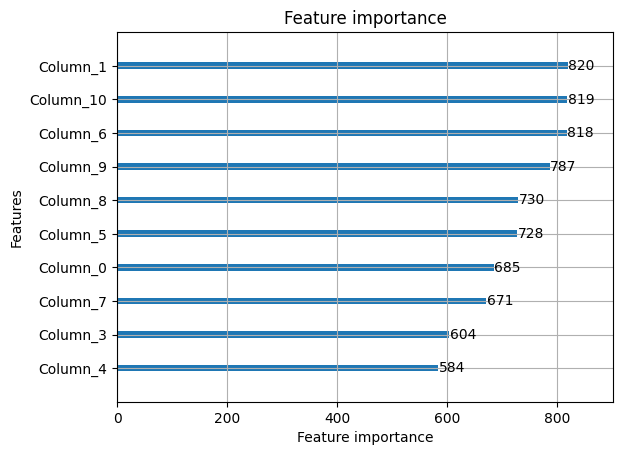

In [23]:

lgb.plot_importance(model, max_num_features=10)
## ??

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

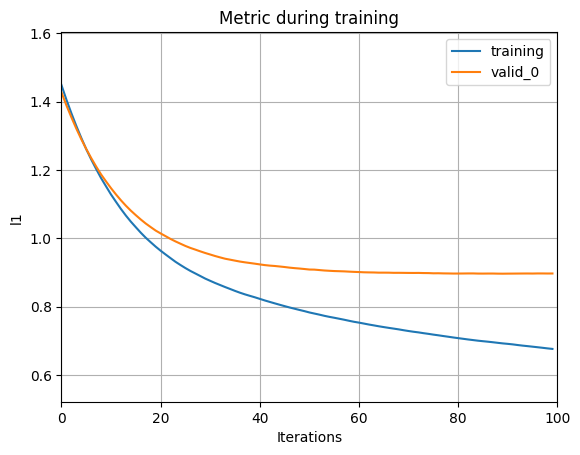

In [24]:
lgb.plot_metric(model,
                metric='l1')